## Random Selection

In [9]:
# Importing Libraries
import pandas as pd
import math
import networkx as nx
import random
from itertools import combinations

# Load the actual dataset
df = pd.read_csv('../../Data/CleanData/illinois.csv')

# Defining the Haversine Function to calculate distances
def haversine(x,y): 
    lon1=x[0]
    lat1=x[1]
    lon2=y[0]
    lat2=y[1]
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 3956 # It is the radius of the earth (needed for the Haversine calculation) in miles. It would be 6371 for kilometers. 
    return c*r

# Preparing Data and Creating a Graph
x=df["longitude"].tolist() 
y=df["latitude"].tolist() 
z=df["zip_code"].tolist() 

zipcodes={}
pos={}
for i in range(len(x)):
    zipcodes[z[i]]=(x[i],y[i]) # storing (x,y) information for each zip code
    pos[z[i]]=(x[i],y[i]) # also storing them to position the nodes in the end.

G=nx.Graph() 
addList=[]
for (i,j) in combinations(zipcodes,2):
    distance=haversine(zipcodes[i],zipcodes[j])
    addList.append(distance)
    G.add_edge(i,j,weight=distance) # creating the graph one pair of zip codes at a time

# Creating a Minimum Spanning Tree
T = nx.minimum_spanning_tree(G)


In [4]:
# Selecting 10 random vertices (nodes) from the tree
random_nodes = random.sample(list(T.nodes), k=10)

# Calculating the average time it takes every node to get to the closest selected vertex
shortest_times = {}
for node in T.nodes:
    shortest_distances = [nx.shortest_path_length(T, source=node, target=r_node, weight='weight') for r_node in random_nodes]
    shortest_time = min(shortest_distances)
    shortest_times[node] = shortest_time

# Display the average times for a few nodes
list(shortest_times.items())[:10]  # Displaying the first 10 for brevity

[(60002, 86.0667187754546),
 (60004, 49.78031165988093),
 (60005, 41.78853858971026),
 (60007, 35.367611181430576),
 (60008, 39.84080993415617),
 (60010, 70.43233072636578),
 (60012, 62.6833076489879),
 (60013, 64.48518628576416),
 (60014, 59.765502016401165),
 (60015, 57.86119562175255)]

In [5]:
# Calculating the Sum of Shortest Distances
sum_times = sum(shortest_times.values())

print(f"Sum of distance is: {sum_times}")
print(f"Avg of distance is: {sum_times/len(T.nodes())}")

Sum of distance is: 113645.16988208116
Avg of distance is: 81.40771481524438


## Optimization Problem

In [51]:
from gurobipy import *

# Assuming the spanning tree 'T' and the set of all nodes are already created
nodes = list(T.nodes)
distances = {(i, j): nx.shortest_path_length(T, source=i, target=j, weight='weight') for i in nodes for j in nodes}

# Initialize the Gurobi model
model = Model("optimal_facilities")

# Decision variables
x = model.addVars(nodes, vtype=GRB.BINARY, name="x")  # Facility selection variables
y = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="y")  # Assignment variables

# Objective function
model.setObjective(quicksum(distances[i, j] * y[i, j] for i in nodes for j in nodes), GRB.MINIMIZE)

# Constraints
# Select exactly 10 facilities
model.addConstr(x.sum() == 10, "select_10")

# Assign each node to exactly one facility
for i in nodes:
    model.addConstr(y.sum(i, '*') == 1, f"assign_{i}")

# Ensure nodes are assigned to open facilities
for i in nodes:
    for j in nodes:
        model.addConstr(y[i, j] <= x[j], f"open_facility_{i}_{j}")

# Optimize the model
model.optimize()

# Extracting the selected nodes (facilities) and the assignments
selected_facilities = [j for j in nodes if x[j].X > 0.5]
assignments = {(i, j): y[i, j].X for i in nodes for j in nodes if y[i, j].X > 0.5}

# Output the selected facilities and assignments
print("Selected Facilities:", selected_facilities)
print("Assignments:", assignments)


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1950213 rows, 1950212 columns and 5847844 nonzeros
Model fingerprint: 0x6b170739
Variable types: 0 continuous, 1950212 integer (1950212 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 466910.83526
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 20s) ...
Presolve time: 20.82s
Presolved: 1950213 rows, 1950212 columns, 5847844 nonzeros
Variable types: 0 continuous, 1950212 integer (1950212 binary)
Fou

In [81]:
sum_dist = 0
for key in list(assignments.keys()):
    shortest_path = nx.shortest_path_length(T, source=key[0], target=key[1], weight='weight')
    sum_dist += shortest_path

print(f"Sum of distance is: {sum_dist}")
print(f"Avg of distance is: {sum_dist/len(T.nodes())}")

Sum of distance is: 73688.76334923465
Avg of distance is: 52.785647098305624


## Visualization

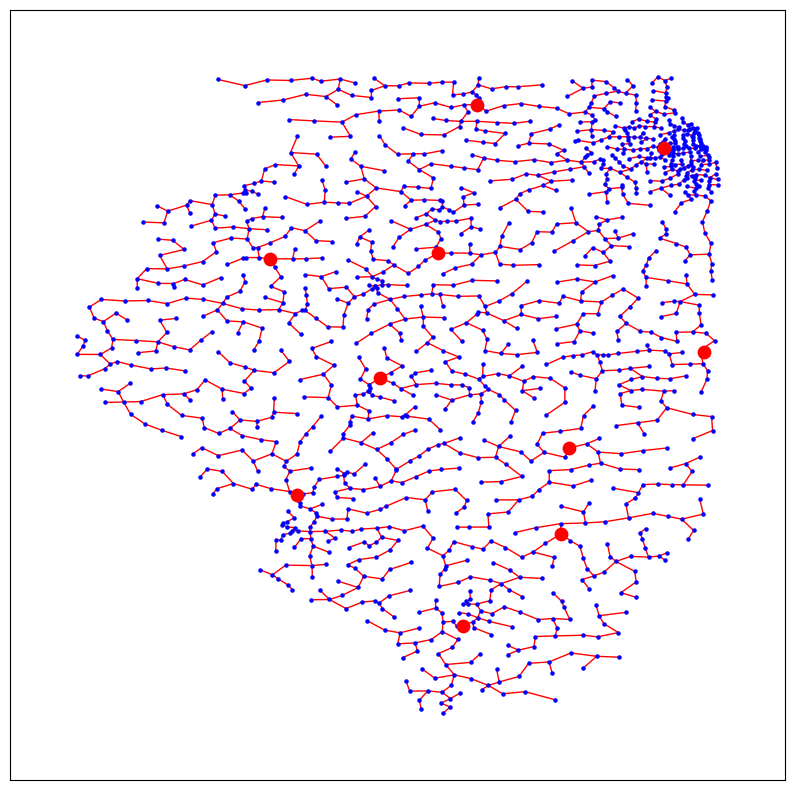

In [21]:
# Plotting the Minimum Spanning Tree
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10] ## set the size of all figures

optimized_list = [60104, 61108, 61448, 61541, 61832, 62018, 62447, 62684, 62878, 62918]

ered=[(i,j) for (i,j) in T.edges()] # selecting the edges in the tree (so that we can edit or show them in the plot)
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(), node_color='b', node_size=5)
nx.draw_networkx_nodes(G,pos,nodelist=optimized_list, node_color='r', node_size=80)
nx.draw_networkx_edges(G,pos,edgelist=ered, edge_color='r', width=1)
plt.savefig("../../Plots/Illinois_Optimized_Location_Graph.png", format="PNG")